In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# to show all results
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

train = pd.read_csv('/content/drive/MyDrive/ds310 /project 2/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/ds310 /project 2/test_data.csv')
sample_sub =  pd.read_csv('/content/drive/MyDrive/ds310 /project 2/sampleSubmission.csv')

Mounted at /content/drive


# Data Cleaning

In [ ]:
train

* We do not need Name variable.
* Class variable is our target variable.
* Sector variable is the only categorical variable.



### summary stat

In [ ]:
train.describe()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.boxplot(train[train.columns[:10]], showfliers=False)
plt.xticks(rotation=90)
plt.title('Boxplot of Train Data')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

We can see that each feature is on different scale. <br/>
So, we have to standardize it in order for feature selection and classification. <br/>
However, we are going to proceed it after cleaning the data.

## balance of target variable

And, we have to check balance of target variable

In [ ]:
class_distribution = train['Class'].value_counts()

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution - Bar Chart')
plt.xticks(ticks=[0, 1], labels=['Not Buy (0)', 'Buy (1)'])

plt.show()

We can observe that the target variable is imbalanced. <br/>
Thus, it is not advised to use accuracy as performance metrics. We will use AUROC for performance metrics.

## checking missingness

check how many rows that do not have any information except 'Sector', 'Name', 'Class'

In [2]:
col_check = train.columns.difference(['Sector', 'Name', 'Class'])

all_na_col = train[col_check].isna().all(axis=0)

print(f"Number of columns without any info (all NA): {all_na_col.count()}")

Number of columns without any info (all NA): 221


check portion of NA values in each feature

In [ ]:
NA_train = train.isna().sum() / len(train)

NA_train_sorted = NA_train.sort_values(ascending = False)

NA_train_sorted

In [ ]:
plt.figure(figsize=(35, 6))
NA_train_sorted.plot(kind='bar')
plt.title('Percentage of NA Values in Each Feature')
plt.xlabel('Features')
plt.ylabel('Percentage of NA Values')
plt.yticks([i/10 for i in range(0, 11)])
plt.show()

# Data preprocessing




## treating missingness

remove rows that do not have any features except 'Sector', 'Name', 'Class'

In [4]:
rows_drop = train[col_check].isna().all(axis=1)

train = train[~rows_drop]

Now, we will treat NA values.
* We will drop columns with more than 50% of missingness.
* We will use KNNImputer for imputating missing values since using either median or mean would affect shape of data.

In [5]:
# features with missingness over 0.5
drop_features = [
    'Name',
    'operatingCycle',
    'cashConversionCycle',
    'shortTermCoverageRatios',
    'operatingProfitMargin'
]

train = train.drop(drop_features, axis = 1)
test = test.drop(drop_features, axis = 1)

In [6]:
train = pd.get_dummies(train, columns = ['Sector'])
test = pd.get_dummies(test, columns = ['Sector'])

In [7]:
from sklearn.impute import KNNImputer

col_impute = train.columns

imputer = KNNImputer(n_neighbors=5)

train[col_impute] = imputer.fit_transform(train[col_impute])

## standardization

During data preprocessing, we also mentioned that each feature is on different sclae. <br/>
Therefore, we will standardize feature scales.


In [8]:
from sklearn.preprocessing import StandardScaler

exclude_columns = ['Class', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities']

train_features = train.drop(columns=exclude_columns)
test_features = test.drop(columns=exclude_columns[1:])  # 'Class' is not on test

scale = StandardScaler()

final_train = scale.fit_transform(train_features)
final_test = scale.transform(test_features)

final_train_df = pd.DataFrame(final_train, columns=train_features.columns)
final_test_df = pd.DataFrame(final_test, columns=test_features.columns)

fr_final_train = pd.concat([train[exclude_columns].reset_index(drop=True), final_train_df], axis=1)
fr_final_test = pd.concat([test[exclude_columns[1:]].reset_index(drop=True), final_test_df], axis=1)

In [9]:
col = ['Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities']

for i in col:
    if fr_final_test[i].dtype == 'bool':
        fr_final_test[i] = fr_final_test[i].astype(int)

## split the dataset into x_train and y_train

now we separate train data into x_train and y_train

In [10]:
X_train = fr_final_train.drop('Class', axis=1)
y_train = fr_final_train['Class']

# feature selection using XGBoost

create XGBoost model

In [14]:
from xgboost import XGBClassifier, plot_importance

xgb = XGBClassifier(random_state = 42,
                    eval_metric='auc',
                    objective='binary:logistic',
                    use_label_encoder=False,)

xgb.fit(X_train, y_train)

,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,priceBookValueRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,ebitperRevenue,ebtperEBIT,niperEBT,grossProfitMargin,pretaxProfitMargin,netProfitMargin,effectiveTaxRate,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,nIperEBT,eBTperEBIT,eBITperRevenue,payablesTurnover,inventoryTurnover,fixedAssetTurnover,assetTurnover,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,daysOfPayablesOutstanding,debtRatio,debtEquityRatio,longtermDebtToCapitalization,totalDebtToCapitalization,interestCoverage,cashFlowToDebtRatio,companyEquityMultiplier,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,payoutRatio,operatingCashFlowSalesRatio,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,capitalExpenditureCoverageRatios,dividendpaidAndCapexCoverageRatios,dividendPayoutRatio,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,ROIC,Return on Tangible Assets,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Days Sales Outstanding,Days Payables Outstanding,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,

feature selection using xgboost

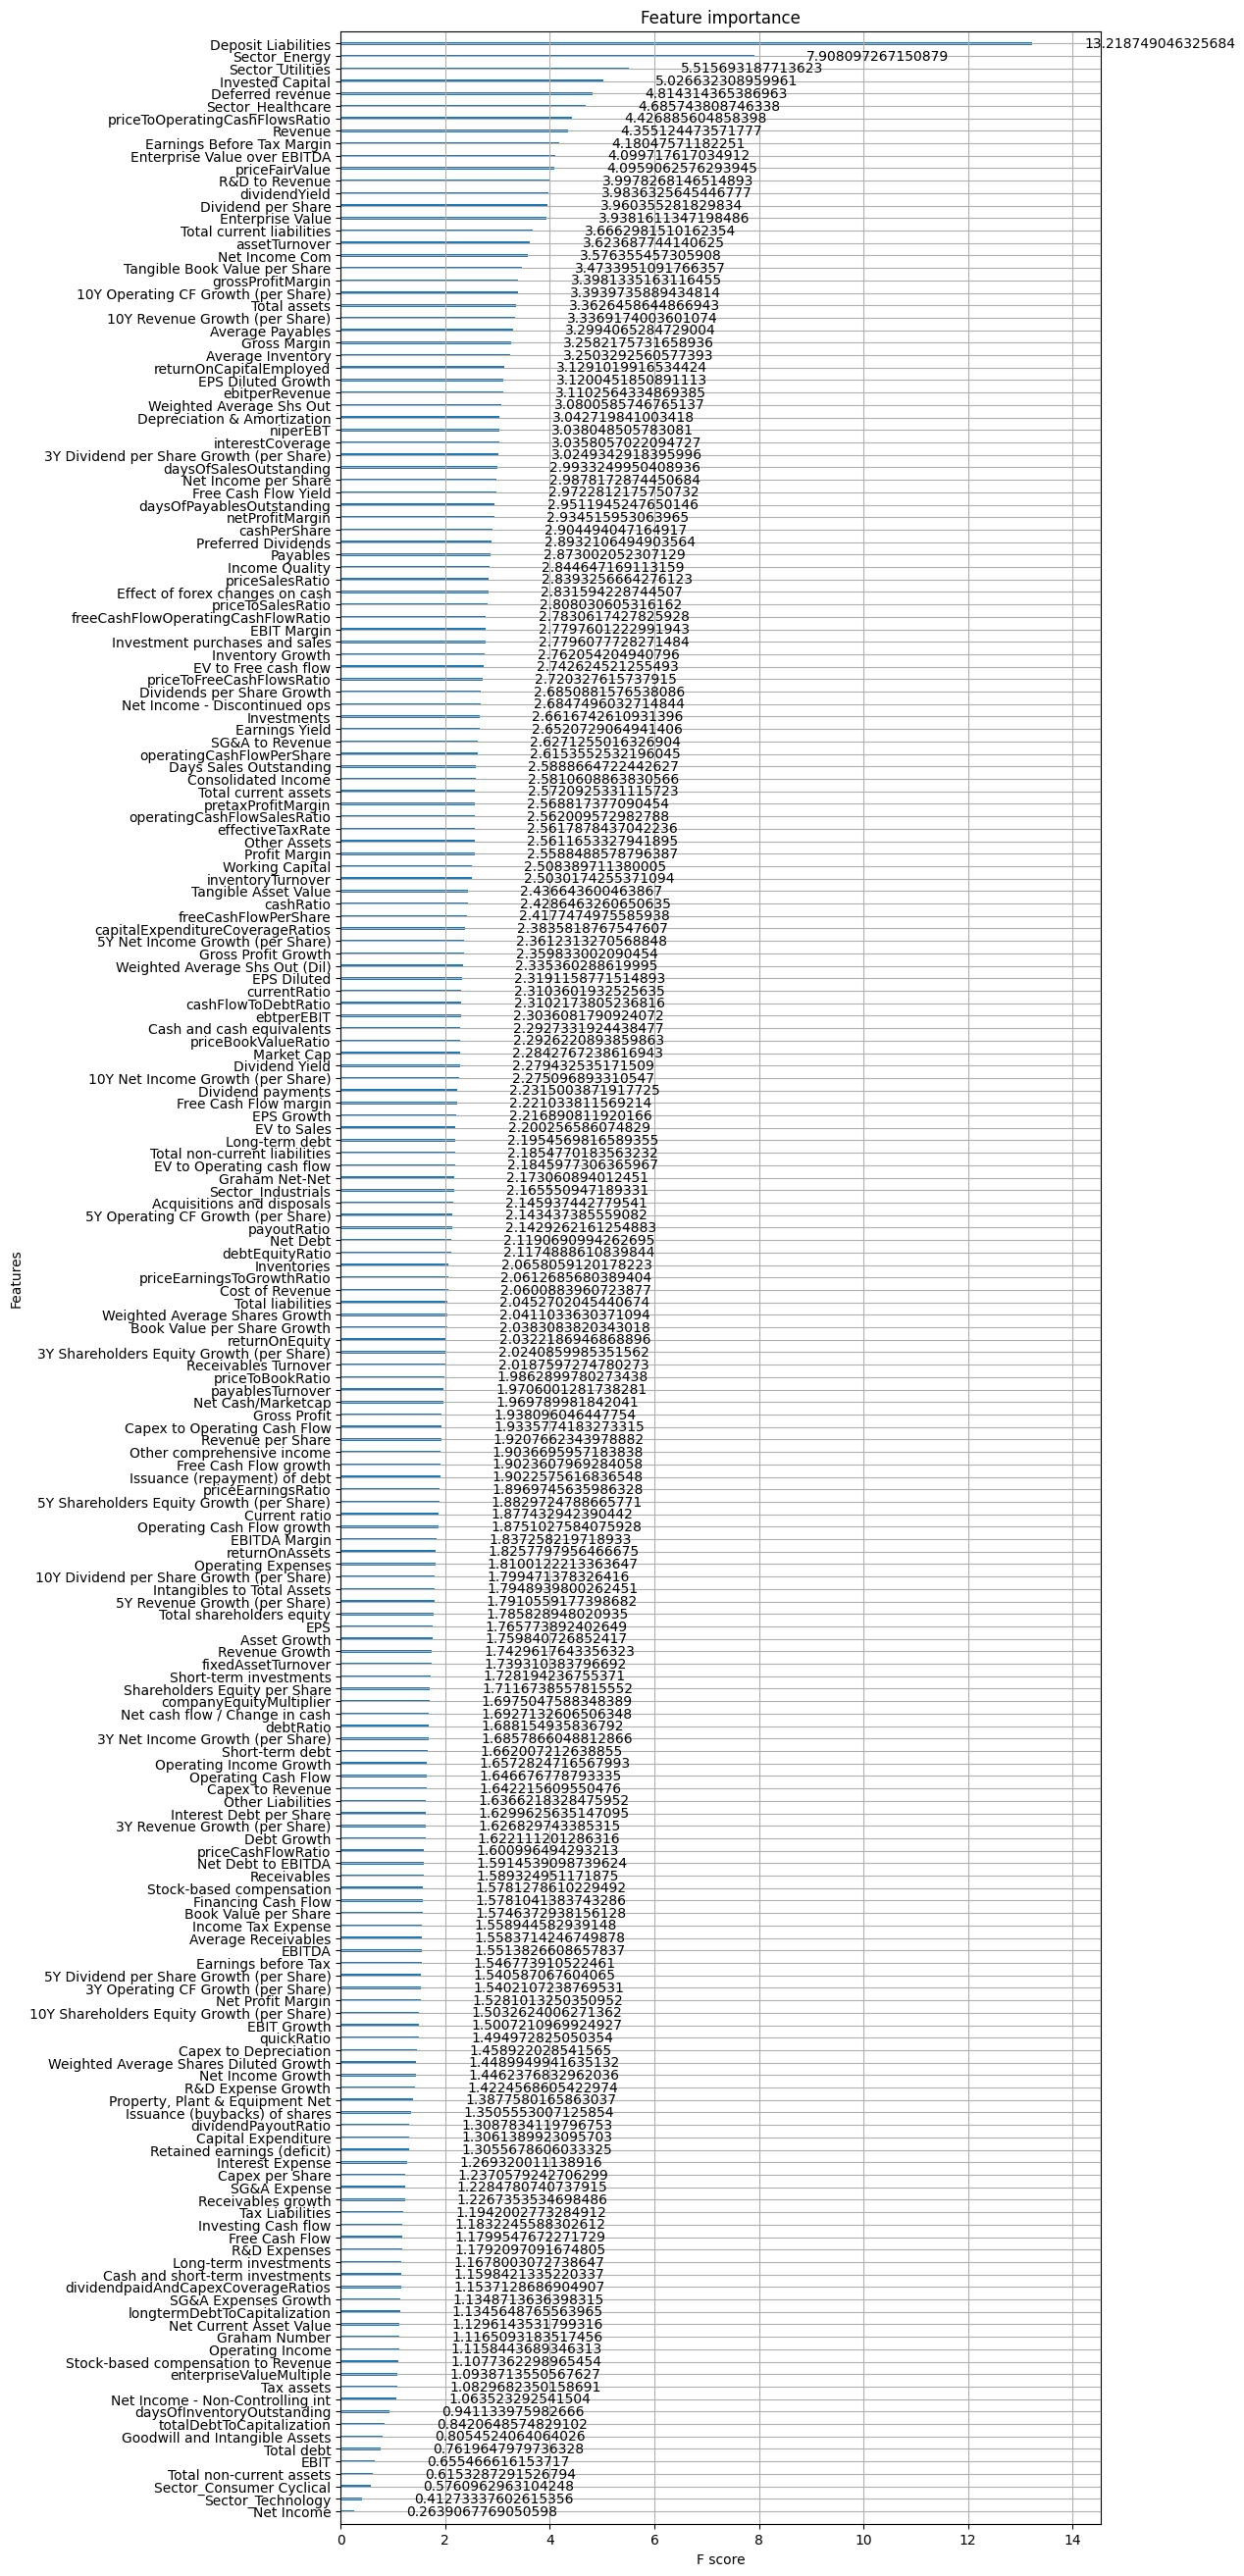

In [24]:
plot_importance(xgb, importance_type='gain')
plt.rcParams["figure.figsize"] = (10,33)
plt.show()

In [ ]:
drop_features2 = [
    "quickRatio",
    "Capex to Depreciation",
    "Weighted Average Shares Diluted Growth",
    "Net Income Growth",
    "R&D Expense Growth",
    "Property, Plant & Equipment Net",
    "Issuance (buybacks) of shares",
    "dividendPayoutRatio",
    "Capital Expenditure",
    "Retained earnings (deficit)",
    "Interest Expense",
    "Capex per Share",
    "SG&A Expense",
    "Receivables growth",
    "Tax Liabilities",
    "Investing Cash flow",
    "Free Cash Flow",
    "R&D Expenses",
    "Long-term investments",
    "Cash and short-term investments",
    "dividendpaidAndCapexCoverageRatios",
    "SG&A Expenses Growth",
    "longtermDebtToCapitalization",
    "Net Current Asset Value",
    "Graham Number",
    "Operating Income",
    "Stock-based compensation to Revenue",
    "enterpriseValueMultiple",
    "Tax assets",
    "Net Income - Non-Controlling int",
    "daysOfInventoryOutstanding",
    "totalDebtToCapitalization",
    "Goodwill and Intangible Assets",
    "Total debt",
    "Total non-current assets",
    "Sector_Consumer Cyclical",
    "Sector_Technology",
    "Net Income"
]


X_train_fr = X_train.drop(columns=drop_features2)
fr_fr_final_test = fr_final_test.drop(columns=drop_features2)

hyperparameter tunning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [2, 4, 6]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose = 1)

grid_search.fit(X_train_fr, y_train)

best_parameters = grid_search.best_params_

create best model using best parameters

In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(fr_fr_final_test)

make a prediction

In [ ]:
sample_sub['Class'] = y_pred

sample_sub.to_csv('/content/drive/MyDrive/ds310 /project 2/submission.csv', index=False)